In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.express as px
import os
import cv2
import pickle
import itertools
import tensorflow as tf
import pydot
import graphviz

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = "/content/drive//MyDrive/Original Images"
test_path = "/content/drive//MyDrive/Original Images"

In [4]:
for folder in os.listdir(train_path):
  sub_path = train_path +'/'+ folder

  print(folder)
  for i in range(1):
    temp_path = os.listdir(sub_path)[1]
    temp_path = sub_path +'/'+ temp_path
    img = mpimg.imread(temp_path)
    implot = plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [5]:
# After reading the images, we then create a function to convert the images into an array.
def imagearray(path, size):
  data = []
  for folder in os.listdir(path):
    sub_path = path + "/" + folder

    for img in os.listdir(sub_path):
      image_path = sub_path + "/" + img
      img_arr = cv2.imread(image_path)
      img_arr = cv2.resize(img_arr, size)
      data.append(img_arr)
  return data

In [6]:
size = (224, 224)

In [7]:
# Here, the images are converted to array and stored in the variable array
images = imagearray(train_path, size)

In [8]:
images = np.array(images)

In [9]:
# the images are then resized so that they maintain the same size for the training purpose

images = images/255

In [10]:
print("images_shape", images.shape)

images_shape (2578, 224, 224, 3)


In [35]:
# Preprocess the training and validation data
image_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [49]:
# Define data augmentation for training images

from pandas.core.arrays import categorical

# The ImageGenerator is used for Data Augmentation, batch loading and class balancing
def data_class(images, size, class_mode):
  datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip
    fill_mode='nearest')
  classes = datagen.flow_from_directory(images,
                                        target_size = size,
                                        batch_size = 32,
                                        class_mode = class_mode,
                                        shuffle = True)

  return classes

In [50]:
#this is used to get the classes for the image dataset and this classes will be alocated as labels for both the training and validation data
train_class = data_class(train_path, size, 'sparse')

Found 2578 images belonging to 31 classes.


In [51]:
labels = train_class.classes

In [52]:
train_class.classes

array([ 0,  0,  0, ..., 30, 30, 30], dtype=int32)

In [53]:
train_class.class_indices

{'Akshay Kumar': 0,
 'Alexandra Daddario': 1,
 'Alia Bhatt': 2,
 'Amitabh Bachchan': 3,
 'Andy Samberg': 4,
 'Anushka Sharma': 5,
 'Billie Eilish': 6,
 'Brad Pitt': 7,
 'Camila Cabello': 8,
 'Charlize Theron': 9,
 'Claire Holt': 10,
 'Courtney Cox': 11,
 'Dwayne Johnson': 12,
 'Elizabeth Olsen': 13,
 'Ellen Degeneres': 14,
 'Henry Cavill': 15,
 'Hrithik Roshan': 16,
 'Hugh Jackman': 17,
 'Jessica Alba': 18,
 'Kashyap': 19,
 'Lisa Kudrow': 20,
 'Margot Robbie': 21,
 'Marmik': 22,
 'Natalie Portman': 23,
 'Priyanka Chopra': 24,
 'Robert Downey Jr': 25,
 'Roger Federer': 26,
 'Tom Cruise': 27,
 'Vijay Deverakonda': 28,
 'Virat Kohli': 29,
 'Zac Efron': 30}

In [54]:
# Now the feature (images) and labels (classes) are splited into train and test sets in the order of 80% and 20% respectively. Also, the split is generated randomly as specified in the code.

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 1234)

In [55]:
print("y_train_shape", y_train.shape,
      "x_train_shape", x_train.shape,
      "y_test_shape", y_test.shape,
      "x_test_shape", x_test.shape)

y_train_shape (2062,) x_train_shape (2062, 224, 224, 3) y_test_shape (516,) x_test_shape (516, 224, 224, 3)


In [56]:
y_train = to_categorical(y_train, num_classes = 31)
y_test = to_categorical(y_test, num_classes = 31)

In [57]:
# Load the InceptionV3 model without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the base model layers
for layer in base_model.layers:
  layer.trainable = False
# Create a new model
model = Sequential()
# Add the base model as a layer
model.add(base_model)
# Add custom layers on top of the base model
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(31, activation='sigmoid'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               13107456  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 31)                7967      
                                                                 
Total params: 34,918,207
Trainable params: 13,115,423
Non-trainable params: 21,802,784
_________________________________________________________________


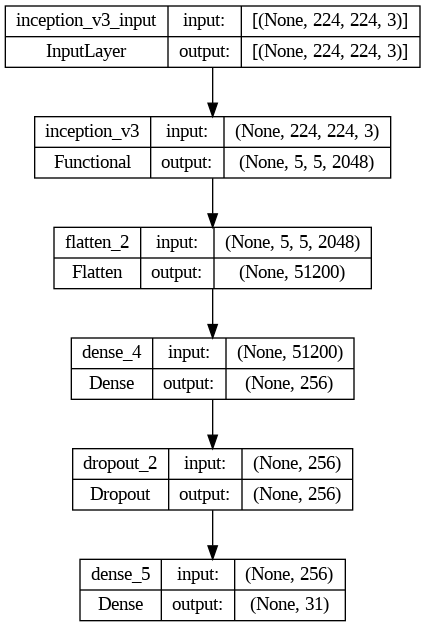

In [59]:
plot_model(model = model, show_shapes = True)

In [60]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 100)

In [62]:
history = model.fit(x_train, y_train, validation_split = 0.2, epochs = 50, callbacks = [early_stop], batch_size = 32, shuffle = True)

Epoch 1/50
52/52 [==============================] - 19s 370ms/step - loss: 3.3067 - accuracy: 0.0746 - val_loss: 3.3358 - val_accuracy: 0.0654
Epoch 2/50
52/52 [==============================] - 19s 366ms/step - loss: 3.3151 - accuracy: 0.0764 - val_loss: 3.3396 - val_accuracy: 0.0557
Epoch 3/50
52/52 [==============================] - 19s 366ms/step - loss: 3.3010 - accuracy: 0.0764 - val_loss: 3.3165 - val_accuracy: 0.0605
Epoch 4/50
52/52 [==============================] - 19s 371ms/step - loss: 3.3007 - accuracy: 0.0758 - val_loss: 3.3079 - val_accuracy: 0.0630
Epoch 5/50
52/52 [==============================] - 19s 370ms/step - loss: 3.2925 - accuracy: 0.0764 - val_loss: 3.3082 - val_accuracy: 0.0630
Epoch 6/50
52/52 [==============================] - 20s 378ms/step - loss: 3.3077 - accuracy: 0.0746 - val_loss: 3.3236 - val_accuracy: 0.0605
Epoch 7/50
52/52 [==============================] - 20s 383ms/step - loss: 3.2947 - accuracy: 0.0776 - val_loss: 3.3041 - val_accuracy: 0.0630

# **MODEL** **Evaluation**

In [63]:
# Save the trained model for future use
model.save('/content/drive//MyDrive/Original Images/face_recognition.tf')

In [64]:
# Evaluate the model on the validation set
loss_v, accuracy_v = model.evaluate(x_train, y_train, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))

65/65 [==============================] - 15s 237ms/step - loss: 3.2526 - accuracy: 0.0805
Validation: accuracy = 0.080504  ;  loss_v = 3.252564


In [65]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

17/17 [==============================] - 4s 228ms/step - loss: 3.3252 - accuracy: 0.0562
Test: accuracy = 0.056202  ;  loss = 3.325174


In [66]:
from sklearn.metrics import precision_recall_fscore_support

# load your test data and the predictions of the CNN model
y_pred = model.predict(x_test) # shape: (num_samples,)

# convert probabilities to class labels (0 or 1) based on a threshold of 0.5
y_pred = np.round(y_pred).astype(int)

# calculate precision, recall, and F1 score
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='samples')

# print the results
print('Precision:', precision)
print('Sensitivity:', recall)
print('F1 score:', f1_score)

17/17 [==============================] - 6s 230ms/step
Precision: 0.041249343356901495
Sensitivity: 0.5794573643410853
F1 score: 0.07666125484182941


17/17 [==============================] - 4s 229ms/step


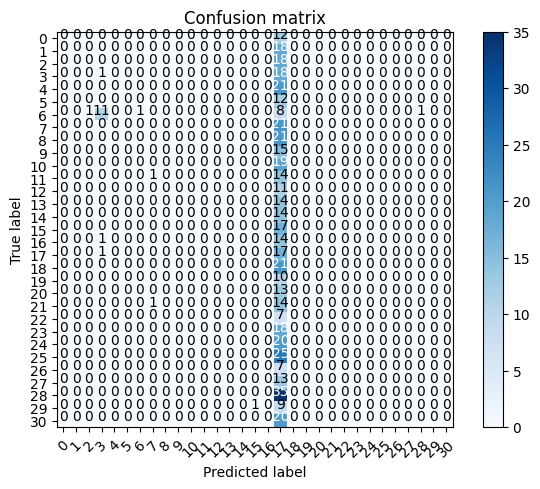

In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(31))

# **Accuracy** **Test**   

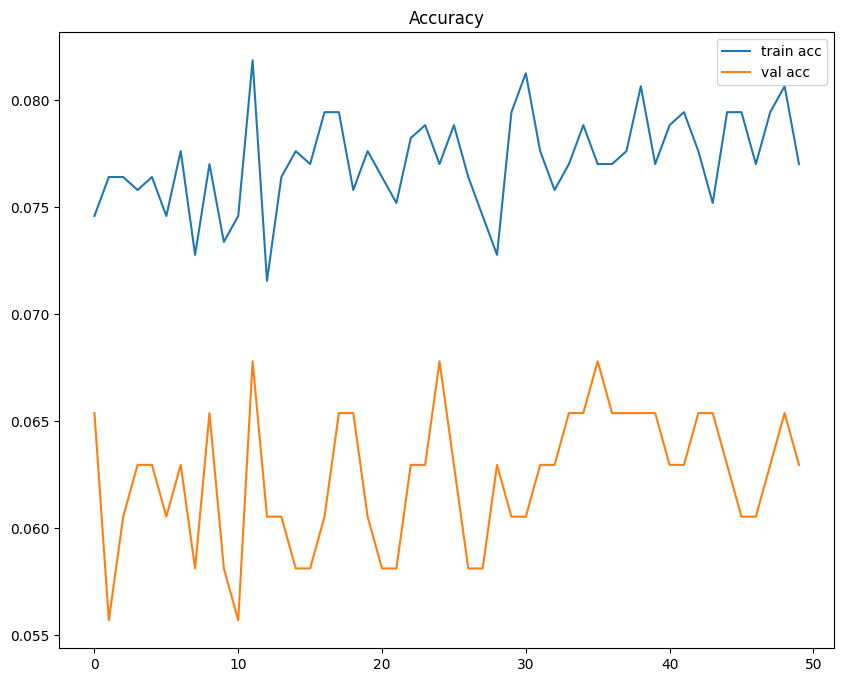

In [69]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

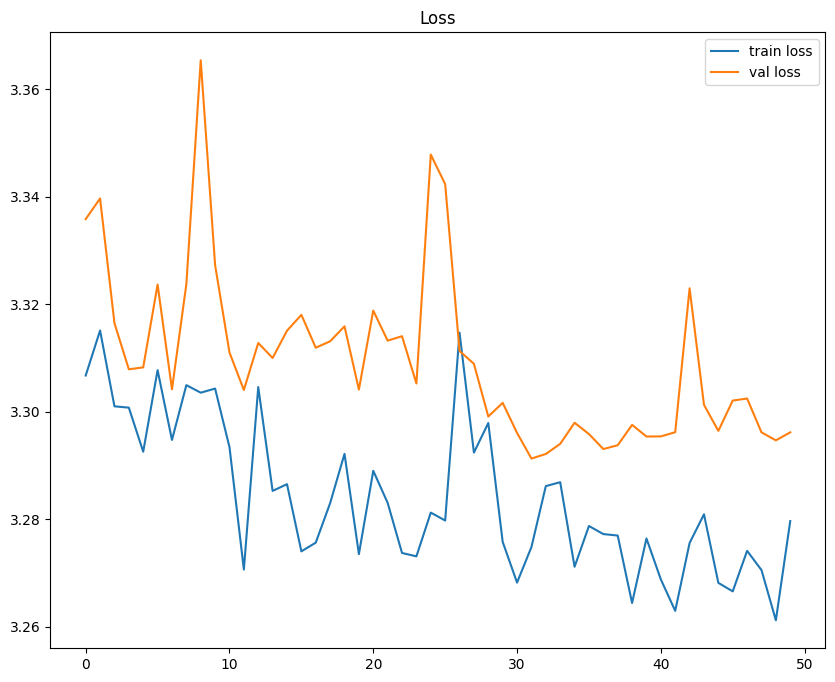

In [70]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()